In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here
%env OPENAI_API_KEY=your_openai_api_key_here


env: OPENROUTER_API_KEY=your_openrouter_api_key_here
env: OPENAI_API_KEY=your_openai_api_key_here


In [2]:
import json
import pandas as pd
import argparse
from os import getenv
import sys
import time
from datetime import datetime, timedelta
from models import TextToSQL, SQLOutput, NoReasoningSQLOutput, NoReasoningSQLOutputReflection, SQLOutputReflection
from utils import describe_database


In [3]:
db_name = 'formula_1'

model_name="openai/gpt-4o-mini"
# model_name = "openai/o4-mini"

 # Load the development questions
print(f"Loading questions for database: {db_name}")
dev_questions = json.load(open('../../dev.json'))
dev_questions = pd.DataFrame(dev_questions)

# Filter questions for the specified database
db_questions = dev_questions[dev_questions['db_id'] == db_name]

print(f'Shape of db_questions: {db_questions.shape}')
print('Shuffling db_questions')
db_questions = db_questions.sample(frac=1).reset_index(drop=True)

train_test_split = 0.6
train_db_questions = db_questions.head(int(len(db_questions) * train_test_split))
test_db_questions = db_questions.tail(int(len(db_questions) * (1 - train_test_split)))

train_db_questions.shape, test_db_questions.shape


Loading questions for database: formula_1
Shape of db_questions: (174, 6)
Shuffling db_questions


((104, 6), (69, 6))

In [4]:
test_db_questions.head(2)

,question_id,db_id,question,evidence,SQL,difficulty
105,1014,formula_1,Please list the lap records for the circuits i...,lap record means the fastest time recorded whi...,"WITH fastest_lap_times AS (SELECT T1.raceId, T...",challenging
106,950,formula_1,Please list the constructor names with 0 point...,race at 291 refers to raceID = 291;,SELECT T2.name FROM constructorStandings AS T1...,simple


In [5]:
sample_t = TextToSQL(
    question="dummy",evidence="dummy", expected_sql="dummy", difficulty="easy",
    
    db_name=db_name,
    db_path=f'../../dbs/dev_databases/{db_name}/{db_name}.sqlite'
)

print(f"Database path: {sample_t.path_to_db()}")
db_description = describe_database(sample_t.path_to_db())
print(db_description)

Database path: ../../dbs/dev_databases/formula_1/formula_1.sqlite

🧱 Table: circuits
   🔸 circuitId (INTEGER)
   🔸 circuitRef (TEXT)
   🔸 name (TEXT)
   🔸 location (TEXT)
   🔸 country (TEXT)
   🔸 lat (REAL)
   🔸 lng (REAL)
   🔸 alt (INTEGER)
   🔸 url (TEXT)

🧱 Table: constructors
   🔸 constructorId (INTEGER)
   🔸 constructorRef (TEXT)
   🔸 name (TEXT)
   🔸 nationality (TEXT)
   🔸 url (TEXT)

🧱 Table: drivers
   🔸 driverId (INTEGER)
   🔸 driverRef (TEXT)
   🔸 number (INTEGER)
   🔸 code (TEXT)
   🔸 forename (TEXT)
   🔸 surname (TEXT)
   🔸 dob (DATE)
   🔸 nationality (TEXT)
   🔸 url (TEXT)

🧱 Table: seasons
   🔸 year (INTEGER)
   🔸 url (TEXT)

🧱 Table: races
   🔸 raceId (INTEGER)
   🔸 year (INTEGER)
   🔸 round (INTEGER)
   🔸 circuitId (INTEGER)
   🔸 name (TEXT)
   🔸 date (DATE)
   🔸 time (TEXT)
   🔸 url (TEXT)
   🔗 Foreign Keys:
      circuitId → circuits.circuitId
      year → seasons.year

🧱 Table: constructorResults
   🔸 constructorResultsId (INTEGER)
   🔸 raceId (INTEGER)
   🔸 constru

In [6]:
# Import ChatPromptTemplate from langchain_core.prompts
from langchain_core.prompts import ChatPromptTemplate

# Create a reusable prompt template
simple_prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You write sql queries given this database\n\n{db_description}\n\nGive all responses in the JSON format:\n\n{schema_json}"),
    ("user", "{question}\n\n{evidence}")
])

# Process each question
for question_num, (idx, row) in enumerate(test_db_questions.iterrows(), 1):
    # Create TextToSQL instance
    t = TextToSQL(
        question=row['question'],
        evidence=row['evidence'] if pd.notna(row['evidence']) else "",
        expected_sql=row['SQL'],
        difficulty=row['difficulty'],
        db_name=db_name,
        db_path=f'../../dbs/dev_databases/{db_name}/{db_name}.sqlite'
    )

    # Format the prompt using the template
    messages = simple_prompt_template.format_messages(
        db_description=db_description,
        schema_json=json.dumps(SQLOutput.model_json_schema(), indent=2),
        question=t.question,
        evidence=t.evidence
    )
        

In [7]:
# Make LLM call
response = t._llm_call(
    prompt=messages,
    model_name=model_name,
    openai_api_key=getenv('OPENROUTER_API_KEY'),
    base_url="https://openrouter.ai/api/v1",
    temperature=0.0
)

In [8]:
response

{'raw': AIMessage(content='{"reasoning":"To find the season page URL for the year when race number 901 took place, I need to first identify the year of that specific race. I will query the \'races\' table to get the year associated with raceId 901. Once I have the year, I will then look up the corresponding URL in the \'seasons\' table. The final output will be the URL from the \'seasons\' table for that year.","sql_query":"SELECT s.url\\nFROM races r\\nJOIN seasons s ON r.year = s.year\\nWHERE r.raceId = 901;"}', additional_kwargs={'parsed': SQLOutput(reasoning="To find the season page URL for the year when race number 901 took place, I need to first identify the year of that specific race. I will query the 'races' table to get the year associated with raceId 901. Once I have the year, I will then look up the corresponding URL in the 'seasons' table. The final output will be the URL from the 'seasons' table for that year.", sql_query='SELECT s.url\nFROM races r\nJOIN seasons s ON r.ye

In [9]:
result = {
    'question_id': question_num,  # Use the sequential question number
    'original_idx': idx,  # Keep the original index for reference
    'db_name': db_name,
    'question': row['question'],
    'evidence': row['evidence'] if pd.notna(row['evidence']) else "",
    'expected_sql': row['SQL'],
    'difficulty': row['difficulty'],
    'generated_sql': None,
    'reasoning': None,
    'query_successful': False,
    'results_match': False,
    'generated_result': None,
    'expected_result': None,
    'error_message': None,
    'model_name': model_name,
}

# Extract generated SQL and reasoning
if 'parsed' in response and response['parsed']:
    result['generated_sql'] = response['parsed'].sql_query
    result['reasoning'] = response['parsed'].reasoning
    
    # Try to run the generated query
    try:
        generated_result = t._run_sql_against_db(response['parsed'].sql_query)
        result['generated_result'] = str(generated_result)
        result['query_successful'] = True
        
        # Compare with expected result
        expected_result = t.expected_answer()
        result['expected_result'] = str(expected_result)
        result['results_match'] = generated_result == expected_result
        
        print(f"✅ Query executed successfully. Match: {result['results_match']}")
        
    except Exception as e:
        result['error_message'] = str(e)
        result['query_successful'] = False
        print(f"❌ Query execution failed: {e}")
else:
    result['error_message'] = "Failed to parse LLM response"
    print("❌ Failed to parse LLM response")

# Get metadata
metadata = t.get_metadata()
result.update({
    'input_tokens': metadata.get('input_tokens', 0),
    'output_tokens': metadata.get('output_tokens', 0),
    'total_tokens': metadata.get('total_tokens', 0),
    'cached_tokens': metadata.get('cached_tokens', 0),
    'latency_seconds': metadata.get('latency_seconds', 0),
    'actual_cost': metadata.get('actual_cost', 0),
    'timestamp': datetime.now().isoformat(),
})

✅ Query executed successfully. Match: True


In [10]:
result

{'question_id': 69,
 'original_idx': 173,
 'db_name': 'formula_1',
 'question': 'Show me the season page of year when the race No. 901 took place.',
 'evidence': 'the season page refers to url; race number refers to raceId;',
 'expected_sql': 'SELECT T2.url FROM races AS T1 INNER JOIN seasons AS T2 ON T2.year = T1.year WHERE T1.raceId = 901',
 'difficulty': 'simple',
 'generated_sql': 'SELECT s.url\nFROM races r\nJOIN seasons s ON r.year = s.year\nWHERE r.raceId = 901;',
 'reasoning': "To find the season page URL for the year when race number 901 took place, I need to first identify the year of that specific race. I will query the 'races' table to get the year associated with raceId 901. Once I have the year, I will then look up the corresponding URL in the 'seasons' table. The final output will be the URL from the 'seasons' table for that year.",
 'query_successful': True,
 'results_match': True,
 'generated_result': "[('http://en.wikipedia.org/wiki/2014_Formula_One_season',)]",
 'exp

In [11]:
'''
# Experiments with prompt engineering
    for each, record price, cost, token efficiency, latency, and accuracy

## Assumptions:
1. the correct evidence was pulled and is in the prompt

## Experiments:
1. Same db 1, 3, 5 random shot (take random examples from the same database from the training set)
    - with and without asking for CoT
2. Any db 1, 3, 5 random shot (take random examples from any database from the training set)
    - with and without asking for CoT
3. Semantic 1, 3, 5 shot (take top semantically similar examples from the same database from the training set)
    - with and without asking for CoT

'''

'\n# Experiments with prompt engineering\n    for each, record price, cost, token efficiency, latency, and accuracy\n\n## Assumptions:\n1. the correct evidence was pulled and is in the prompt\n\n## Experiments:\n1. Same db 1, 3, 5 random shot (take random examples from the same database from the training set)\n    - with and without asking for CoT\n2. Any db 1, 3, 5 random shot (take random examples from any database from the training set)\n    - with and without asking for CoT\n3. Semantic 1, 3, 5 shot (take top semantically similar examples from the same database from the training set)\n    - with and without asking for CoT\n\n4. Reflection maybe? For a select few prompts, add a second step to ask the LLM to reflect on the sql and the reasoning and improve it if necessary.\n\n\n\n\n\n'

In [12]:
from typing import TypedDict, Optional, List, Dict, Any
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
import random
from langchain_core.prompts import ChatPromptTemplate

# Define the state for our experiment
class ExperimentState(TypedDict):
    # Experiment configuration
    reflection: bool  # will the LLM reflect on the code and output a second draft
    k_shot: Optional[int]  # Number of examples (1, 3, 5, or None for zero-shot)
    cot: bool  # Chain of thought reasoning
    experiment_type: str  # "same_db", "any_db", "semantic", "reflection"
    model_name: str  # Model to use
    
    # Current question data
    question: str
    evidence: str
    expected_sql: str
    difficulty: str
    db_name: str
    
    # Database info
    db_description: str
    
    # Training examples (for few-shot)
    training_examples: List[Dict[str, Any]]
    selected_examples: List[Dict[str, Any]]
    chroma_db_path: Optional[str]

    # System-wide settings
    verbose: bool = False
    
    # Prompt and results
    final_prompt: Any  # The compiled prompt
    llm_response: Optional[Dict[str, Any]]
    result: Optional[Dict[str, Any]]

def route_experiment(state: ExperimentState) -> str:
    """Route to the appropriate experiment node based on experiment type"""
    if state["k_shot"] is None or state["k_shot"] == 0:
        return "compile_prompt"  # Zero-shot, skip example selection
    
    experiment_type = state["experiment_type"]
    if experiment_type == "same_db":
        return "select_same_db_examples"
    elif experiment_type == "any_db":
        return "select_any_db_examples"
    elif experiment_type == "semantic":
        return "select_semantic_examples"
    else:
        return "compile_prompt"

def select_same_db_examples(state: ExperimentState) -> ExperimentState:
    """Select random examples from the same database"""
    k = state["k_shot"]
    current_db = state["db_name"]
    
    # Filter training examples for same database
    same_db_examples = [ex for ex in state["training_examples"] if ex["db_id"] == current_db]
    
    # Randomly select k examples
    selected = random.sample(same_db_examples, min(k, len(same_db_examples)))
    
    state["selected_examples"] = selected
    return state

def select_any_db_examples(state: ExperimentState) -> ExperimentState:
    """Select random examples from any database"""
    k = state["k_shot"]
    
    # Randomly select k examples from all training data
    selected = random.sample(state["training_examples"], min(k, len(state["training_examples"])))
    
    state["selected_examples"] = selected
    return state

def select_semantic_examples(state: ExperimentState) -> ExperimentState:
    """Select semantically similar examples using pre-initialized ChromaDB"""
    from langchain_chroma import Chroma
    from langchain_openai import OpenAIEmbeddings
    import chromadb
    from chromadb.config import Settings
    import os
    
    k = state["k_shot"]
    current_db = state["db_name"]
    current_question = state["question"]
    chroma_db_path = state.get("chroma_db_path")
    verbose = state.get("verbose", False)
    # Filter training examples for same database as fallback
    same_db_examples = [ex for ex in state["training_examples"] if ex["db_id"] == current_db]
    
    if len(same_db_examples) == 0:
        state["selected_examples"] = []
        return state
    
    # If no ChromaDB path provided, fall back to length-based similarity
    if not chroma_db_path:
        print("⚠️ No ChromaDB path provided, falling back to length-based similarity")
        current_len = len(current_question)
        same_db_examples.sort(key=lambda x: abs(len(x["question"]) - current_len))
        selected = same_db_examples[:min(k, len(same_db_examples))]
        state["selected_examples"] = selected
        return state
    
    try:
        # Use the existing ChromaDB client with compatible settings
        chroma_client = chromadb.PersistentClient(
            path=chroma_db_path,
            settings=Settings(
                anonymized_telemetry=False,
                allow_reset=True,
                is_persistent=True
            )
        )
        
        # Get the collection directly without creating a new vector store
        collection_name = f"questions_{current_db}"
        collection = chroma_client.get_collection(name=collection_name)
        
        # Initialize embeddings (using OpenAI text-embedding-3-small)
        embeddings = OpenAIEmbeddings(
            model="text-embedding-3-small",
            openai_api_key=os.getenv('OPENAI_API_KEY') or os.getenv('OPENROUTER_API_KEY')
        )
        
        # Get embedding for the current question
        query_embedding = embeddings.embed_query(current_question)
        
        # Perform semantic search using ChromaDB's native query method
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=min(k, len(same_db_examples))
        )
        
        # Convert results back to example format
        selected = []
        for i, (doc, metadata, distance) in enumerate(zip(
            results['documents'][0], 
            results['metadatas'][0], 
            results['distances'][0]
        )):
            example = {
                "db_id": metadata["db_id"],
                "question": metadata["question"],
                "SQL": metadata["sql"],
                "evidence": metadata["evidence"],
                "difficulty": metadata["difficulty"]
            }
            selected.append(example)
            # ChromaDB returns distance (lower is more similar), convert to similarity score
            similarity_score = 1 - distance
            if verbose:
                print(f"  📄 Similarity: {similarity_score:.4f} | Question: {metadata['question'][:80]}...")
        
        state["selected_examples"] = selected
        
    except Exception as e:
        print(f"❌ Error in semantic search, falling back to length-based similarity: {e}")
        # Fallback to length-based similarity if ChromaDB fails
        current_len = len(current_question)
        same_db_examples.sort(key=lambda x: abs(len(x["question"]) - current_len))
        selected = same_db_examples[:min(k, len(same_db_examples))]
        state["selected_examples"] = selected
    
    return state

def compile_prompt(state: ExperimentState) -> ExperimentState:
    """Compile the final prompt based on experiment configuration"""
    
    # Base system message
    system_parts = ["You write sql queries given this database", state["db_description"]]
    
    # Add examples if we have any
    if state.get("selected_examples"):
        system_parts.append("Here are some examples:")
        
        for i, example in enumerate(state["selected_examples"], 1):
            example_text = f"\nExample {i}:\nQuestion: {example['question']}"
            if example.get('evidence'):
                example_text += f"\nEvidence: {example['evidence']}"
            example_text += f"\nSQL: {example['SQL']}"
            system_parts.append(example_text)
    
    # Add CoT instruction if enabled
    if state["cot"]:
        system_parts.append("Think step by step and explain your reasoning before writing the SQL query.")
    
    # system_parts.append("Give all responses in the JSON format:")
    # system_parts.append(json.dumps(SQLOutput.model_json_schema(), indent=2))
    
    system_message = "\n\n".join(system_parts)
    
    # Create the prompt template
    if state["cot"]:
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", system_message),
            ("user", "{question}\n\n{evidence}\n\nPlease think step by step and provide your reasoning before the SQL query.")
        ])
    else:
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", system_message),
            ("user", "{question}\n\n{evidence}")
        ])
    
    # Format the final prompt
    final_prompt = prompt_template.format_messages(
        question=state["question"],
        evidence=state["evidence"]
    )
    
    state["final_prompt"] = final_prompt
    return state

def run_llm(state: ExperimentState) -> ExperimentState:
    """Execute the LLM call and process results"""
    
    # Create TextToSQL instance for the current question
    t = TextToSQL(
        question=state["question"],
        evidence=state["evidence"],
        expected_sql=state["expected_sql"],
        difficulty=state["difficulty"],
        db_name=state["db_name"],
        db_path=f'../../dbs/dev_databases/{state["db_name"]}/{state["db_name"]}.sqlite'
    )

    output_model_to_use = None
    if state["reflection"]:
        if state["cot"]:
            output_model_to_use = SQLOutputReflection
        else:
            output_model_to_use = NoReasoningSQLOutputReflection
    else:
        if state["cot"]:
            output_model_to_use = SQLOutput
        else:
            output_model_to_use = NoReasoningSQLOutput
    
    # Make LLM call
    response = t._llm_call(
        prompt=state["final_prompt"],
        model_name=state["model_name"],
        openai_api_key=getenv('OPENROUTER_API_KEY'),
        base_url="https://openrouter.ai/api/v1",
        temperature=0.0,
        structured_output=output_model_to_use
    )
    
    # Process results
    result = {
        'experiment_type': state["experiment_type"],
        'k_shot': state["k_shot"],
        'cot': state["cot"],
        'model_name': state["model_name"],
        'question': state["question"],
        'evidence': state["evidence"],
        'expected_sql': state["expected_sql"],
        'difficulty': state["difficulty"],
        'generated_sql': None,
        'reasoning': None,
        'query_successful': False,
        'results_match': False,
        'generated_result': None,
        'expected_result': None,
        'error_message': None,
        "final_prompt": state["final_prompt"]
    }
    
    # Extract generated SQL and reasoning
    if 'parsed' in response and response['parsed']:
        result['generated_sql'] = response['parsed'].sql_query
        if state["cot"]:
            result['reasoning'] = response['parsed'].reasoning
        else:
            result['reasoning'] = None
        
        # Try to run the generated query
        try:
            generated_result = t._run_sql_against_db(response['parsed'].sql_query)
            result['generated_result'] = str(generated_result)
            result['query_successful'] = True
            
            # Compare with expected result
            expected_result = t.expected_answer()
            result['expected_result'] = str(expected_result)
            result['results_match'] = generated_result == expected_result
            
        except Exception as e:
            result['error_message'] = str(e)
            result['query_successful'] = False
    else:
        result['error_message'] = "Failed to parse LLM response"
    
    # Add metadata
    metadata = t.get_metadata()
    result.update({
        'input_tokens': metadata.get('input_tokens', 0),
        'output_tokens': metadata.get('output_tokens', 0),
        'total_tokens': metadata.get('total_tokens', 0),
        'cached_tokens': metadata.get('cached_tokens', 0),
        'latency_seconds': metadata.get('latency_seconds', 0),
        'actual_cost': metadata.get('actual_cost', 0),
        'timestamp': datetime.now().isoformat(),
    })
    
    state["llm_response"] = response
    state["result"] = result
    return state

# Create the graph
def create_experiment_graph() -> CompiledStateGraph:
    """Create and compile the experiment graph"""
    
    # Create the state graph
    graph = StateGraph(ExperimentState)
    
    # Add nodes
    graph.add_node("select_same_db_examples", select_same_db_examples)
    graph.add_node("select_any_db_examples", select_any_db_examples)
    graph.add_node("select_semantic_examples", select_semantic_examples)
    graph.add_node("compile_prompt", compile_prompt)
    graph.add_node("run_llm", run_llm)
    
    # Add conditional routing from start
    graph.add_conditional_edges(
        START,
        route_experiment,
        {
            "select_same_db_examples": "select_same_db_examples",
            "select_any_db_examples": "select_any_db_examples", 
            "select_semantic_examples": "select_semantic_examples",
            "compile_prompt": "compile_prompt"
        }
    )
    
    # All example selection nodes go to compile_prompt
    graph.add_edge("select_same_db_examples", "compile_prompt")
    graph.add_edge("select_any_db_examples", "compile_prompt")
    graph.add_edge("select_semantic_examples", "compile_prompt")
    
    # compile_prompt goes to run_llm
    graph.add_edge("compile_prompt", "run_llm")
    
    # run_llm goes to END
    graph.add_edge("run_llm", END)
    
    # Compile the graph
    return graph.compile()

# Create the compiled graph
experiment_graph = create_experiment_graph()

print("✅ LangGraph experiment flow created successfully!")
print("Graph nodes:", list(experiment_graph.get_graph().nodes.keys()))
print("Available experiments: same_db, any_db, semantic")

✅ LangGraph experiment flow created successfully!
Graph nodes: ['__start__', 'select_same_db_examples', 'select_any_db_examples', 'select_semantic_examples', 'compile_prompt', 'run_llm', '__end__']
Available experiments: same_db, any_db, semantic


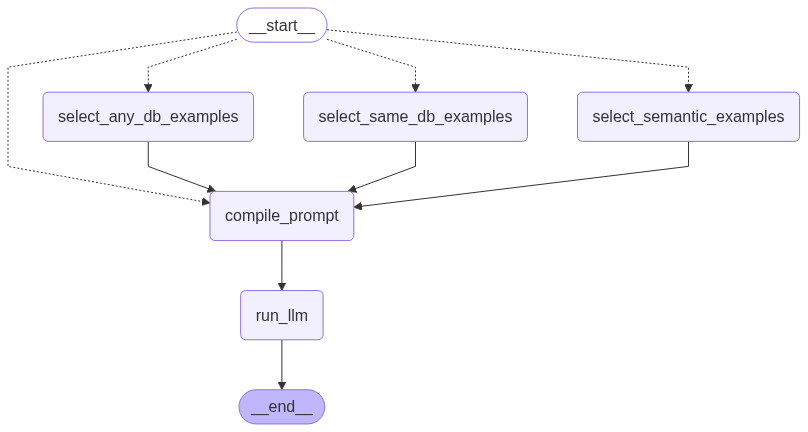

In [13]:
from IPython.display import Image, display

display(Image(experiment_graph.get_graph().draw_mermaid_png()))

In [14]:
training_examples = train_db_questions.to_dict('records')

len(training_examples)

104

In [15]:
# Initialize and populate ChromaDB for semantic similarity
import chromadb
from chromadb.config import Settings
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
import os

# remove path if exists
import shutil

def remove_path(path):
    if os.path.exists(path):
        shutil.rmtree(path) 
    else:
        print(f"🔧 No existing ChromaDB found at {path}")
        return None 


def setup_chromadb_for_experiments(training_examples, db_name):
    """Set up and populate ChromaDB with training examples for semantic similarity"""
    
    # ChromaDB path for this database - use absolute path
    current_dir = os.getcwd()
    chroma_db_path = os.path.join(current_dir, f"chromadb_semantic_{db_name}")

    remove_path(chroma_db_path)
    print(f"🔧 Setting up ChromaDB for {db_name} at {chroma_db_path}")
    
    # Create directory with proper permissions
    os.makedirs(chroma_db_path, mode=0o755, exist_ok=True)
    
    try:
        # Initialize ChromaDB client with better settings
        chroma_client = chromadb.PersistentClient(
            path=chroma_db_path,
            settings=Settings(
                anonymized_telemetry=False,
                allow_reset=True,
                is_persistent=True
            )
        )
        
        # Initialize embeddings (using OpenAI text-embedding-3-small)
        embeddings = OpenAIEmbeddings(
            model="text-embedding-3-small",
            openai_api_key=os.getenv('OPENAI_API_KEY') or os.getenv('OPENROUTER_API_KEY')
        )
        
        # Set up collection with cosine similarity
        collection_name = f"questions_{db_name}"
        collection_metadata = {"hnsw:space": "cosine"}
        
        # Initialize vector store
        vector_store = Chroma(
            client=chroma_client,
            collection_name=collection_name,
            embedding_function=embeddings,
            collection_metadata=collection_metadata
        )
        
        # Check if collection exists and has documents
        try:
            collection = chroma_client.get_collection(name=collection_name)
            doc_count = collection.count()
            print(f"📊 Found existing collection with {doc_count} documents")
        except:
            doc_count = 0
            print("📊 No existing collection found")
        
        # Filter training examples for this database
        same_db_examples = [ex for ex in training_examples if ex["db_id"] == db_name]
        
        # If collection is empty or has fewer documents than training examples, populate it
        if doc_count < len(same_db_examples):
            print(f"🔄 Populating ChromaDB with {len(same_db_examples)} questions for {db_name}")
            
            # Clear existing collection if it exists
            if doc_count > 0:
                chroma_client.delete_collection(name=collection_name)
                vector_store = Chroma(
                    client=chroma_client,
                    collection_name=collection_name,
                    embedding_function=embeddings,
                    collection_metadata=collection_metadata
                )
            
            # Prepare documents and metadata
            documents = []
            metadatas = []
            ids = []
            
            for i, example in enumerate(same_db_examples):
                documents.append(example["question"])
                metadatas.append({
                    "db_id": example["db_id"],
                    "question": example["question"],
                    "sql": example["SQL"],
                    "evidence": example.get("evidence", ""),
                    "difficulty": example.get("difficulty", ""),
                    "example_index": i
                })
                ids.append(f"{db_name}_{i}")
            
            # Add documents to vector store
            docs = [Document(page_content=doc, metadata=meta) for doc, meta in zip(documents, metadatas)]
            vector_store.add_documents(docs, ids=ids)
            
            print(f"✅ Added {len(documents)} questions to ChromaDB")
            
            # Verify the population
            final_count = chroma_client.get_collection(name=collection_name).count()
            print(f"📊 Final document count: {final_count}")
        
        else:
            print(f"✅ ChromaDB already populated with {doc_count} documents")
        
        return chroma_db_path
        
    except Exception as e:
        print(f"❌ Error setting up ChromaDB: {e}")
        return None

# Set up ChromaDB for the current database
chroma_db_path = setup_chromadb_for_experiments(training_examples, db_name)

print(f"🎯 ChromaDB path: {chroma_db_path}")


🔧 Setting up ChromaDB for formula_1 at /Users/sinanozdemir/Teaching/Pearson/applied-ai-book/text_to_sql/src/choosing_generator/chromadb_semantic_formula_1
📊 Found existing collection with 0 documents
🔄 Populating ChromaDB with 104 questions for formula_1
✅ Added 104 questions to ChromaDB
📊 Final document count: 104
🎯 ChromaDB path: /Users/sinanozdemir/Teaching/Pearson/applied-ai-book/text_to_sql/src/choosing_generator/chromadb_semantic_formula_1


In [7]:
# Define experiment configurations
experiment_configs = [
    # Zero-shot experiments
    {"k_shot": None, "cot": False, "reflection": False, "experiment_type": "same_db", "name": "0 Shot"},
    {"k_shot": None, "cot": True, "reflection": False, "experiment_type": "same_db", "name": "0 Shot (CoT)"},
    
    {"k_shot": None, "cot": False, "reflection": True, "experiment_type": "same_db", "name": "0 Shot (Reflection)"},
    {"k_shot": None, "cot": True, "reflection": True, "experiment_type": "same_db", "name": "0 Shot (CoT + Reflection)"},
    
    # Same DB experiments  
    {"k_shot": 1, "cot": False, "reflection": False, "experiment_type": "same_db", "name": "1 Shot Same DB"},
    {"k_shot": 1, "cot": True, "reflection": False, "experiment_type": "same_db", "name": "1 Shot Same DB (CoT)"},

    {"k_shot": 1, "cot": False, "reflection": True, "experiment_type": "same_db", "name": "1 Shot Same DB (Reflection)"},
    {"k_shot": 1, "cot": True, "reflection": True, "experiment_type": "same_db", "name": "1 Shot Same DB (CoT + Reflection)"},

    {"k_shot": 3, "cot": False, "reflection": False, "experiment_type": "same_db", "name": "3 Shot Same DB"},
    {"k_shot": 3, "cot": True, "reflection": False, "experiment_type": "same_db", "name": "3 Shot Same DB (CoT)"},

    {"k_shot": 3, "cot": False, "reflection": True, "experiment_type": "same_db", "name": "3 Shot Same DB (Reflection)"},
    {"k_shot": 3, "cot": True, "reflection": True, "experiment_type": "same_db", "name": "3 Shot Same DB (CoT + Reflection)"},
    
    # Any DB experiments
    {"k_shot": 1, "cot": False, "reflection": False, "experiment_type": "any_db", "name": "1 Shot Any DB"},
    {"k_shot": 1, "cot": True, "reflection": False, "experiment_type": "any_db", "name": "1 Shot Any DB (CoT)"},

    {"k_shot": 3, "cot": False, "reflection": False, "experiment_type": "any_db", "name": "3 Shot Any DB"},
    {"k_shot": 3, "cot": True, "reflection": False, "experiment_type": "any_db", "name": "3 Shot Any DB (CoT)"},

    # Semantic experiments
    {"k_shot": 1, "cot": False, "reflection": False, "experiment_type": "semantic", "name": "1 Shot Semantic"},
    {"k_shot": 1, "cot": True, "reflection": False, "experiment_type": "semantic", "name": "1 Shot Semantic (CoT)"},

    {"k_shot": 1, "cot": False, "reflection": True, "experiment_type": "semantic", "name": "1 Shot Semantic (Reflection)"},
    {"k_shot": 1, "cot": True, "reflection": True, "experiment_type": "semantic", "name": "1 Shot Semantic (CoT + Reflection)"},

    {"k_shot": 3, "cot": False, "reflection": False, "experiment_type": "semantic", "name": "3 Shot Semantic"},
    {"k_shot": 3, "cot": True, "reflection": False, "experiment_type": "semantic", "name": "3 Shot Semantic (CoT)"},

    {"k_shot": 3, "cot": False, "reflection": True, "experiment_type": "semantic", "name": "3 Shot Semantic (Reflection)"},
    {"k_shot": 3, "cot": True, "reflection": True, "experiment_type": "semantic", "name": "3 Shot Semantic (CoT + Reflection)"},
]

In [17]:
# Comprehensive experiment runner for all configurations with ETA
from tqdm import tqdm
import time

def run_all_experiments(test_questions_df, max_questions=2, number_of_times_per_question=1):
    """
    Run all experiment configurations on a subset of test questions, possibly multiple times per question.
    
    Args:
        test_questions_df: DataFrame with test questions
        max_questions: Maximum number of questions to test (to save time/cost)
        number_of_times_per_question: Number of times to run each experiment per question (for robustness)
    """
    
    all_results = []
    
    # Take subset of questions to test
    test_subset = test_questions_df.head(max_questions)
    total_experiments = len(experiment_configs) * len(test_subset) * number_of_times_per_question
    
    print(f"🚀 Starting {len(experiment_configs)} experiment configurations on {len(test_subset)} questions")
    print(f"📊 Total experiments: {total_experiments} (including {number_of_times_per_question} runs per question)")
    print("-" * 80)
    
    # Create progress bar for all experiments
    with tqdm(total=total_experiments, desc="🔬 Running Experiments", 
              unit="exp", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]") as pbar:
        
        start_time = time.time()
        
        for config_idx, config in enumerate(experiment_configs, 1):
            pbar.set_description(f"🔬 {config['name']}")
            
            for question_idx, (_, test_row) in enumerate(test_subset.iterrows(), 1):
                for run_idx in range(1, number_of_times_per_question + 1):
                    experiment_start_time = time.time()
                    
                    # Set up the initial state
                    initial_state = {
                        "k_shot": config["k_shot"],
                        "cot": config["cot"],
                        "experiment_type": config["experiment_type"],
                        "model_name": model_name,
                        "reflection": config["reflection"],
                        "verbose": config.get("verbose", False),
                        
                        # Current question data
                        "question": test_row['question'],
                        "evidence": test_row['evidence'] if pd.notna(test_row['evidence']) else "",
                        "expected_sql": test_row['SQL'],
                        "difficulty": test_row['difficulty'],
                        "db_name": db_name,
                        
                        # Database info
                        "db_description": db_description,
                        
                        # Training examples for few-shot
                        "training_examples": training_examples,
                        "chroma_db_path": chroma_db_path,
                        "selected_examples": [],
                        
                        # Initialize other fields
                        "final_prompt": None,
                        "llm_response": None,
                        "result": None,
                        "verbose": False
                    }
                    
                    try:
                        # Run the experiment through the graph
                        result = experiment_graph.invoke(initial_state)
                        
                        # Add configuration info to result
                        result["result"]["experiment_name"] = config["name"]
                        result["result"]["question_id"] = question_idx
                        result["result"]["run_number"] = run_idx
                        
                        all_results.append(result["result"])
                        
                        # Update progress with result
                        match_status = "✅" if result["result"]["results_match"] else "❌"
                        experiment_time = time.time() - experiment_start_time
                        
                        pbar.set_postfix({
                            'Status': match_status,
                            'Time': f'{experiment_time:.1f}s',
                            'Question': f'{question_idx}/{len(test_subset)}',
                            'Run': f'{run_idx}/{number_of_times_per_question}'
                        })
                        
                    except Exception as e:
                        # Add error result
                        error_result = {
                            "experiment_name": config["name"],
                            "question_id": question_idx,
                            "run_number": run_idx,
                            "error_message": str(e),
                            "results_match": False,
                            "query_successful": False
                        }
                        all_results.append(error_result)
                        
                        pbar.set_postfix({
                            'Status': '❌',
                            'Error': str(e)[:20] + '...' if len(str(e)) > 20 else str(e),
                            'Run': f'{run_idx}/{number_of_times_per_question}'
                        })
                    
                    # Update progress bar
                    pbar.update(1)
    
    total_time = time.time() - start_time
    print(f"\n🎉 Experiments completed in {total_time/60:.1f} minutes!")
    print(f"📈 Average time per experiment: {total_time/total_experiments:.1f} seconds")
    
    return all_results

# Function to analyze results
def analyze_experiment_results(results):
    """Analyze and summarize experiment results"""
    df = pd.DataFrame(results)
    
    print("\n📊 EXPERIMENT RESULTS SUMMARY")
    print("=" * 50)
    
    # Group by experiment name
    summary = df.groupby('experiment_name').agg({
        'results_match': ['count', 'sum', 'mean'],
        'query_successful': 'mean',
        'actual_cost': 'sum',
        'total_tokens': 'sum',
        'latency_seconds': 'mean'
    }).round(3)
    
    print(summary)
    
    # Best performing experiments
    accuracy_by_experiment = df.groupby('experiment_name')['results_match'].mean().sort_values(ascending=False)
    
    print(f"\n🏆 TOP PERFORMING EXPERIMENTS:")
    for i, (exp_name, accuracy) in enumerate(accuracy_by_experiment.head(5).items(), 1):
        print(f"{i}. {exp_name}: {accuracy:.1%} accuracy")
    
    return df

In [18]:
results = run_all_experiments(test_db_questions, max_questions=None, number_of_times_per_question=2)
df_results = analyze_experiment_results(results)

🚀 Starting 24 experiment configurations on 69 questions
📊 Total experiments: 3312 (including 2 runs per question)
--------------------------------------------------------------------------------


🔬 3 Shot Semantic (CoT + Reflection): 100%|██████████| 3312/3312 [3:29:46<00:00,  3.80s/exp]  


🎉 Experiments completed in 209.8 minutes!
📈 Average time per experiment: 3.8 seconds

📊 EXPERIMENT RESULTS SUMMARY
                                   results_match            query_successful  \
                                           count sum   mean             mean   
experiment_name                                                                
0 Shot                                       138  46  0.333            0.971   
0 Shot (CoT + Reflection)                    138  49  0.355            0.971   
0 Shot (CoT)                                 138  49  0.355            0.978   
0 Shot (Reflection)                          138  46  0.333            0.964   
1 Shot Any DB                                138  53  0.384            0.913   
1 Shot Any DB (CoT)                          138  52  0.377            0.913   
1 Shot Same DB                               138  53  0.384            0.935   
1 Shot Same DB (CoT + Reflection)            138  54  0.391            0.971   
1 Sh

In [19]:
agg_df = df_results.groupby(['experiment_name', 'question_id']).agg({
    'results_match': ['mean', 'std'],
    'query_successful': 'mean',
    'latency_seconds': 'median'
}).round(3)

# Print only the rows where std is not 0
std_col = ('results_match', 'std')
if std_col in agg_df.columns:
    print(agg_df[agg_df[std_col] != 0])
else:
    print("No std column found in aggregation.")

                                         results_match         \
                                                  mean    std   
experiment_name              question_id                        
0 Shot                       46                    0.5  0.707   
                             47                    0.5  0.707   
0 Shot (CoT + Reflection)    57                    0.5  0.707   
                             65                    0.5  0.707   
                             68                    0.5  0.707   
...                                                ...    ...   
3 Shot Semantic (Reflection) 21                    0.5  0.707   
                             26                    0.5  0.707   
                             60                    0.5  0.707   
                             62                    0.5  0.707   
                             69                    0.5  0.707   

                                         query_successful latency_seconds  
             

In [20]:
df_results.to_csv(f'experiment_results_{db_name}.csv')
df_results.tail()

,experiment_type,k_shot,cot,model_name,question,evidence,expected_sql,difficulty,generated_sql,reasoning,...,input_tokens,output_tokens,total_tokens,cached_tokens,latency_seconds,actual_cost,timestamp,experiment_name,question_id,run_number
3307,semantic,3.0,True,openai/gpt-4o-mini,Which race has the shortest actual finishing t...,shortest actual finishing time refers to Min(m...,"SELECT T1.name, T1.year FROM races AS T1 INNER...",simple,"SELECT r.name, r.year FROM results AS res INNE...",To find the race with the shortest actual fini...,...,1416,377,1793,1280,5.410323,0.000014,2025-06-22T11:10:46.247226,3 Shot Semantic (CoT + Reflection),67,2
3308,semantic,3.0,True,openai/gpt-4o-mini,Which year was the first Singapore Grand Prix?,the first race refers to race happened in min(...,SELECT year FROM races WHERE name = 'Singapore...,simple,SELECT MIN(year) FROM races WHERE name = 'Sing...,To find the year of the first Singapore Grand ...,...,1708,211,1919,1408,3.252794,0.000011,2025-06-22T11:10:49.769297,3 Shot Semantic (CoT + Reflection),68,1
3309,semantic,3.0,True,openai/gpt-4o-mini,Which year was the first Singapore Grand Prix?,the first race refers to race happened in min(...,SELECT year FROM races WHERE name = 'Singapore...,simple,SELECT MIN(year) AS first_year FROM races WHER...,To find the year of the first Singapore Grand ...,...,1708,213,1921,1664,3.547480,0.000010,2025-06-22T11:10:53.525295,3 Shot Semantic (CoT + Reflection),68,2
3310,semantic,3.0,True,openai/gpt-4o-mini,Show me the season page of year when the race ...,the season page refers to url; race number ref...,SELECT T2.url FROM races AS T1 INNER JOIN seas...,simple,SELECT s.url FROM seasons AS s INNER JOIN race...,To find the season page URL for the year when ...,...,1444,239,1683,1280,3.505650,0.000011,2025-06-22T11:10:57.268429,3 Shot Semantic (CoT + Reflection),69,1
3311,semantic,3.0,True,openai/gpt-4o-mini,Show me the season page of year when the race ...,the season page refers to url; race number ref...,SELECT T2.url FROM races AS T1 INNER JOIN seas...,simple,SELECT s.url FROM seasons AS s INNER JOIN race...,To find the season page URL for the year when ...,...,1444,239,1683,1408,3.597433,0.000010,2025-06-22T11:11:01.079635,3 Shot Semantic (CoT + Reflection),69,2


In [18]:
import pandas as pd
db_name = 'formula_1'
model_name = 'gpt-4o-mini'
df_results = pd.read_csv(f'experiment_results_{db_name}.csv')
# remove rows with reflection
df_results = df_results[~df_results['experiment_name'].str.contains('Reflection')]
experiment_configs = [e for e in experiment_configs if 'reflection' not in e['name'].lower()]

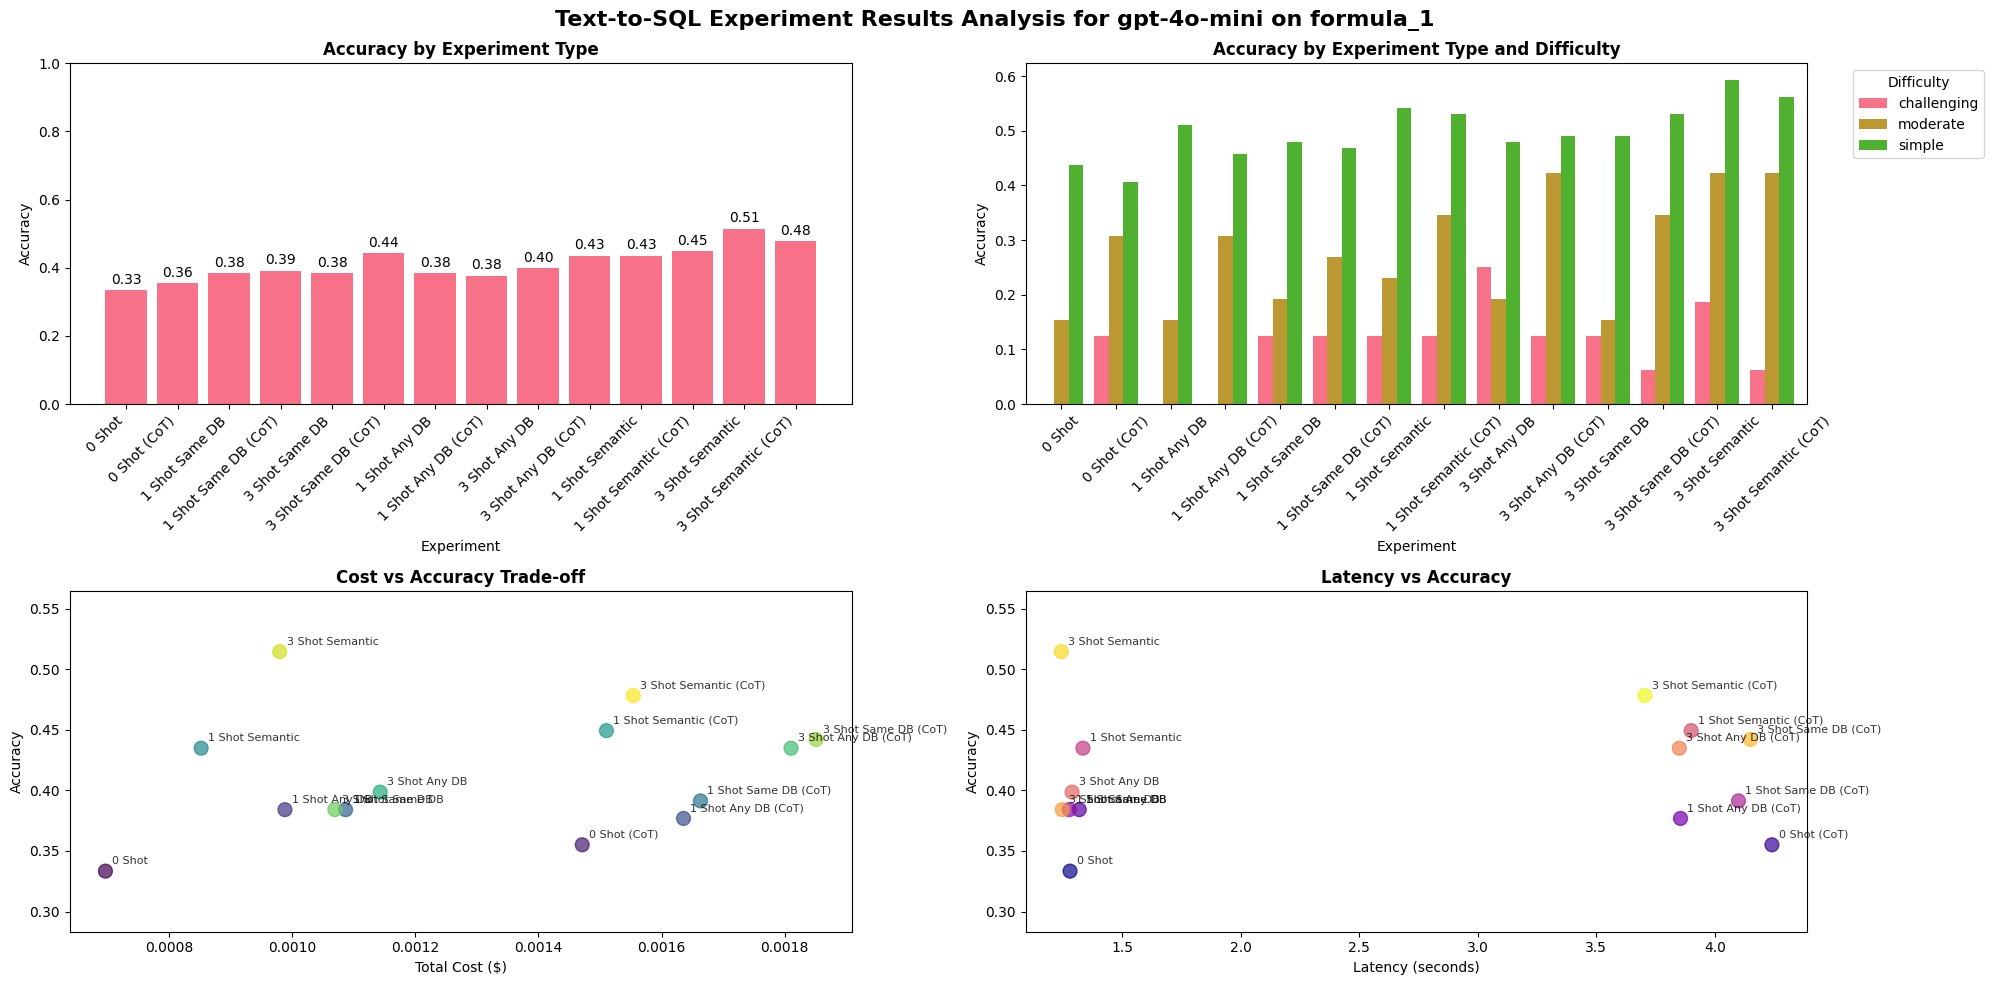

In [19]:
# Visualize experiment results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_experiment_results(df):
    """Create visualizations for experiment results"""

    try:
        experiment_order = [conf["name"] for conf in experiment_configs]
    except Exception:
        # fallback: use sorted unique model names in df
        experiment_order = sorted(df["name"].unique()) if "name" in df.columns else []

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f'Text-to-SQL Experiment Results Analysis for {model_name} on {db_name}', fontsize=16, fontweight='bold')

    # 1. Accuracy by Experiment Type
    # Sort according to the order in experiment_configs
    experiment_order = [conf["name"] for conf in experiment_configs]
    
    accuracy_by_exp = df.groupby('experiment_name')['results_match'].mean().reset_index()
    # Set experiment_name as categorical for custom sorting
    accuracy_by_exp['experiment_name'] = pd.Categorical(
        accuracy_by_exp['experiment_name'],
        categories=experiment_order,
        ordered=True
    )
    accuracy_by_exp = accuracy_by_exp.sort_values('experiment_name')

    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(accuracy_by_exp)), accuracy_by_exp['results_match'].values)
    ax1.set_title('Accuracy by Experiment Type', fontweight='bold')
    ax1.set_xlabel('Experiment')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(range(len(accuracy_by_exp)))
    ax1.set_xticklabels(accuracy_by_exp['experiment_name'], rotation=45, ha='right')
    ax1.set_ylim(0, 1)
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')

    # 2. Accuracy by Experiment and Difficulty
    if 'difficulty' in df.columns:
        accuracy_pivot = df.groupby(['experiment_name', 'difficulty'])['results_match'].mean().unstack(fill_value=0)
        ax2 = axes[0, 1]
        accuracy_pivot.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_title('Accuracy by Experiment Type and Difficulty', fontweight='bold')
        ax2.set_xlabel('Experiment')
        ax2.set_ylabel('Accuracy')
        ax2.legend(title='Difficulty', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.tick_params(axis='x', rotation=45)

    # 3. Cost vs Accuracy
    cost_acc = df.groupby('experiment_name').agg({
        'results_match': 'mean',
        'actual_cost': 'sum'
    }).reset_index()
    ax3 = axes[1, 0]
    scatter = ax3.scatter(cost_acc['actual_cost'], cost_acc['results_match'],
                            s=100, alpha=0.7, c=range(len(cost_acc)), cmap='viridis')
    ax3.set_title('Cost vs Accuracy Trade-off', fontweight='bold')
    ax3.set_xlabel('Total Cost ($)')
    ax3.set_ylabel('Accuracy')
    y_min = max(0, cost_acc['results_match'].min() - 0.05)
    y_max = min(1, cost_acc['results_match'].max() + 0.05)
    ax3.set_ylim(y_min, y_max)
    for i, row in cost_acc.iterrows():
        ax3.annotate(row['experiment_name'],
                    (row['actual_cost'], row['results_match']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)

    # 4. Latency vs Accuracy (Scatter Plot)
    latency_acc = df.groupby('experiment_name').agg({
        'results_match': 'mean',
        'latency_seconds': 'median'
    }).reset_index().sort_index()
    ax4 = axes[1, 1]
    scatter4 = ax4.scatter(
        latency_acc['latency_seconds'],
        latency_acc['results_match'],
        s=100, alpha=0.7, c=range(len(latency_acc)), cmap='plasma'
    )
    ax4.set_title('Latency vs Accuracy', fontweight='bold')
    ax4.set_xlabel('Latency (seconds)')
    ax4.set_ylabel('Accuracy')
    y_min = max(0, latency_acc['results_match'].min() - 0.05)
    y_max = min(1, latency_acc['results_match'].max() + 0.05)
    ax4.set_ylim(y_min, y_max)
    for i, row in latency_acc.iterrows():
        ax4.annotate(
            row['experiment_name'],
            (row['latency_seconds'], row['results_match']),
            xytext=(5, 5), textcoords='offset points',
            fontsize=8, alpha=0.8
        )

    plt.tight_layout()
    plt.show()
    # save the figure
    fig.savefig(f'experiment_results_{db_name}_.png')

    return fig

# Visualize the results
if 'df_results' in locals():
    visualize_experiment_results(df_results)
else:
    print("No results to visualize. Run experiments first!")


[]


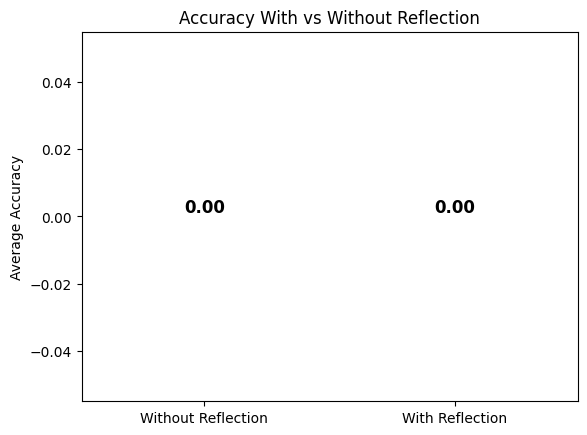

In [20]:
# Find all pairs of experiments that differ only by reflection (with/without) and plot accuracy difference by shots

experiment_pairs = []
for experiment_config in experiment_configs:
    if experiment_config.get('reflection', False):
        for experiment_config2 in experiment_configs:
            # if everything is the same except for reflection, add to experiment_pairs
            if not experiment_config2.get('reflection', False) and experiment_config2.get('shots') == experiment_config.get('shots') and experiment_config2.get('cot') == experiment_config.get('cot') and experiment_config2.get('experiment_type') == experiment_config.get('experiment_type') and experiment_config2.get('k_shot') == experiment_config.get('k_shot'):
                experiment_pairs.append((experiment_config, experiment_config2))

print(experiment_pairs)

# Plot the accuracy difference between experiment pairs that differ only by reflection
without_reflection_accuracy, with_reflection_accuracy = [], []
for experiment_pair in experiment_pairs:
    experiment_names = [experiment_pair[0]['name'], experiment_pair[1]['name']]
    for experiment_name in experiment_names:
        df_results_filtered = df_results[df_results['experiment_name'] == experiment_name]
        if 'reflection' in experiment_name.lower():
            with_reflection_accuracy.append(df_results_filtered['results_match'].mean())
        else:
            without_reflection_accuracy.append(df_results_filtered['results_match'].mean())

values = [
    sum(without_reflection_accuracy) / len(without_reflection_accuracy) if without_reflection_accuracy else 0,
    sum(with_reflection_accuracy) / len(with_reflection_accuracy) if with_reflection_accuracy else 0
]
labels = ['Without Reflection', 'With Reflection']

bars = plt.bar(labels, values)

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.ylabel('Average Accuracy')
plt.title('Accuracy With vs Without Reflection')
plt.savefig('reflection_accuracy_with_vs_without.png')
plt.show()

[({'k_shot': 1, 'cot': False, 'reflection': False, 'experiment_type': 'semantic', 'name': '1 Shot Semantic'}, {'k_shot': 1, 'cot': False, 'reflection': False, 'experiment_type': 'same_db', 'name': '1 Shot Same DB'}), ({'k_shot': 1, 'cot': True, 'reflection': False, 'experiment_type': 'semantic', 'name': '1 Shot Semantic (CoT)'}, {'k_shot': 1, 'cot': True, 'reflection': False, 'experiment_type': 'same_db', 'name': '1 Shot Same DB (CoT)'}), ({'k_shot': 3, 'cot': False, 'reflection': False, 'experiment_type': 'semantic', 'name': '3 Shot Semantic'}, {'k_shot': 3, 'cot': False, 'reflection': False, 'experiment_type': 'same_db', 'name': '3 Shot Same DB'}), ({'k_shot': 3, 'cot': True, 'reflection': False, 'experiment_type': 'semantic', 'name': '3 Shot Semantic (CoT)'}, {'k_shot': 3, 'cot': True, 'reflection': False, 'experiment_type': 'same_db', 'name': '3 Shot Same DB (CoT)'})]
['1 Shot Semantic', '1 Shot Same DB']
['1 Shot Semantic (CoT)', '1 Shot Same DB (CoT)']
['3 Shot Semantic', '3 Shot

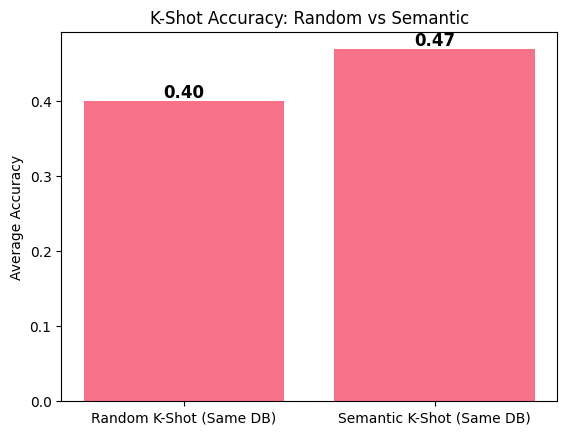

In [21]:
# Find all pairs of experiments that differ only by semantic (with/without) and plot accuracy difference by shots

semantic_experiment_pairs = []
for experiment_config in experiment_configs:
    if experiment_config.get('experiment_type', '').lower() == 'semantic':
        for experiment_config2 in experiment_configs:
            # if everything is the same except for experiment_type (semantic vs not), add to semantic_experiment_pairs
            if experiment_config2.get('experiment_type', '').lower() != 'semantic' \
                and experiment_config2.get('shots') == experiment_config.get('shots') \
                and experiment_config2.get('cot') == experiment_config.get('cot') \
                and experiment_config2.get('k_shot') == experiment_config.get('k_shot') \
                and 'any' not in experiment_config2.get('name').lower() \
                and experiment_config2.get('reflection', False) == experiment_config.get('reflection', False):
                semantic_experiment_pairs.append((experiment_config, experiment_config2))

print(semantic_experiment_pairs)

# Plot the accuracy difference between experiment pairs that differ only by semantic
without_semantic_accuracy, with_semantic_accuracy = [], []
for experiment_pair in semantic_experiment_pairs:
    experiment_names = [experiment_pair[0]['name'], experiment_pair[1]['name']]
    print(experiment_names)
    for experiment_name in experiment_names:
        df_results_filtered = df_results[df_results['experiment_name'] == experiment_name]
        if 'semantic' in experiment_name.lower():
            
            with_semantic_accuracy.append(df_results_filtered['results_match'].mean())
        else:
            without_semantic_accuracy.append(df_results_filtered['results_match'].mean())

semantic_values = [
    sum(without_semantic_accuracy) / len(without_semantic_accuracy) if without_semantic_accuracy else 0,
    sum(with_semantic_accuracy) / len(with_semantic_accuracy) if with_semantic_accuracy else 0
]
semantic_labels = ['Random K-Shot (Same DB)', 'Semantic K-Shot (Same DB)']

semantic_bars = plt.bar(semantic_labels, semantic_values)

# Add value labels on top of each bar
for bar, value in zip(semantic_bars, semantic_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.ylabel('Average Accuracy')
plt.title('K-Shot Accuracy: Random vs Semantic')
plt.savefig('k_shot_accuracy_random_vs_semantic.png')
plt.show()


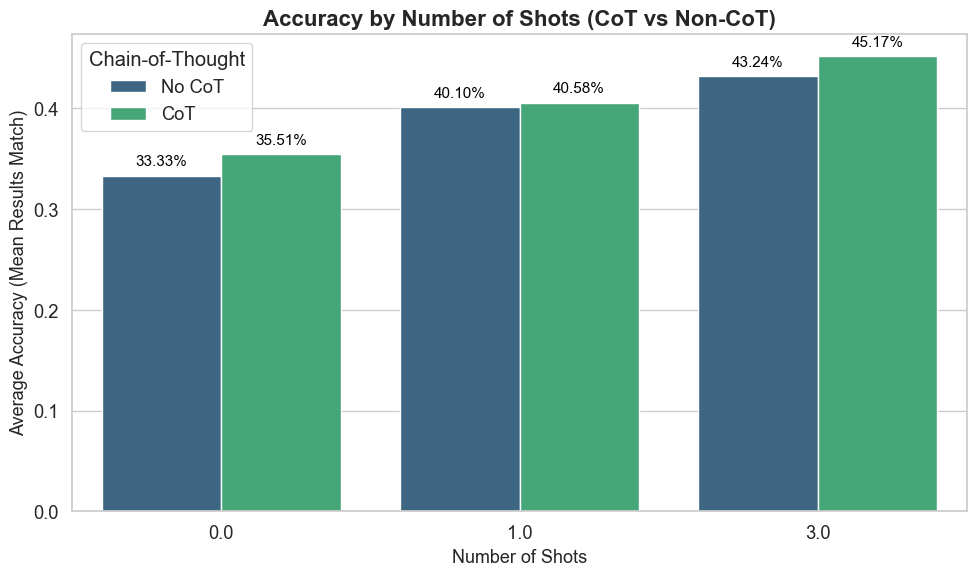

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract number of shots as integer for sorting and plotting
df_results['shots'] = df_results['experiment_name'].str.extract(r'(\d+)').astype(float)

# Ensure 'cot' column is boolean for grouping
if df_results['cot'].dtype != bool:
    df_results['cot'] = df_results['cot'].astype(bool)

# Aggregate by number of shots and CoT
agg_df = (
    df_results
    .groupby(['shots', 'cot'])
    .agg({
        'results_match': 'mean',
        'actual_cost': 'sum'
    })
    .reset_index()
    .sort_values(['shots', 'cot'])
)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Barplot: accuracy by number of shots, split by CoT
bar = sns.barplot(
    data=agg_df,
    x='shots',
    y='results_match',
    hue='cot',
    palette='viridis'
)
bar.set_title('Accuracy by Number of Shots (CoT vs Non-CoT)', fontsize=16, fontweight='bold')
bar.set_xlabel('Number of Shots', fontsize=13)
bar.set_ylabel('Average Accuracy (Mean Results Match)', fontsize=13)

# Fix legend: use clear, explicit labels for CoT
handles, _ = bar.get_legend_handles_labels()
cot_labels = {False: "No CoT", True: "CoT"}
unique_cot = sorted(agg_df['cot'].unique())
labels = [cot_labels[bool_val] for bool_val in unique_cot]
bar.legend(handles=handles, title='Chain-of-Thought', labels=labels)

# Annotate bars
for p in bar.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0:
        bar.annotate(f"{height:.2%}", 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('avg_accuracy_by_shots_cot.png')
plt.show()

In [23]:
# Run a sample with verbose=True, without using run_all_experiments

initial_state = {
    "cot": True,
    "semantic": True,
    "random": False,
    "verbose": True,
    "reflection": False,
    "k_shot": 3,
    "experiment_name": "single_example",
    "experiment_type": "single_example",
    "db_description": describe_database(TextToSQL(
        question="dummy",
        evidence="dummy",
        expected_sql="dummy",
        difficulty="easy",
        db_name=db_name,
        db_path=f'../../dbs/dev_databases/{db_name}/{db_name}.sqlite'
    ).path_to_db()),
    "chroma_db_path": f"./chromadb_semantic_{db_name}",
    "model_name": model_name,
}

# Get the first datapoint from the test set
question = test_db_questions.iloc[0]

initial_state["question"] = question["question"]
initial_state["evidence"] = question["evidence"]
initial_state["expected_sql"] = question["SQL"]
initial_state["difficulty"] = question["difficulty"]
initial_state["db_name"] = db_name

# Create the compiled graph
experiment_graph = create_experiment_graph()


# run the experiment by calling the graph
results = experiment_graph.invoke(initial_state)


NameError: name 'describe_database' is not defined

In [24]:
results['result']

NameError: name 'results' is not defined